In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns

# Author: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
# License: BSD (3-clause)
from matplotlib.colors import TwoSlopeNorm

import os.path as op
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mne_connectivity import spectral_connectivity_epochs, seed_target_indices
from mne.stats import combine_adjacency, spatio_temporal_cluster_test
from mne.channels import find_ch_adjacency

from mne.datasets import sample
from mne_connectivity.viz import plot_sensors_connectivity
from mne.stats import permutation_cluster_test
from scipy import stats as stats
from functools import partial

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
dict015= {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FT9':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg','FT10':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','TP9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','TP10':'eeg','P7':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_imp = {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','FT9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','FT10':'eeg','TP9':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_exp = dict015

dict011_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg','T7':'eeg','FT10':'eeg',
               'CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'FT9':'eeg', 'TP10':'eeg','P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg',
               'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
              'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict011_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FT10':'eeg', 'FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
               'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'TP9':'eeg', 'P8':'eeg','P4':'eeg','Pz':'eeg',
               'P3':'eeg','P7':'eeg','O2':'eeg', 'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs',
               'DBS6-7':'dbs','DBS7-8':'dbs', 'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}
           
    
#'DBS1-234':'dbs','DBS234-567':'dbs','DBS567-8':'dbs','mean(DBS1-234, DBS234-567, DBS567-8)':'dbs',

dict08_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',             
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict08_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FC6':'eeg', 'FC2':'eeg','FC1':'eeg','FC5':'eeg',
                'T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg', 'T7':'eeg','FT10':'eeg', 'CP6':'eeg','CP2':'eeg',
                'CP1':'eeg','CP5':'eeg','FT9':'eeg','TP10':'eeg', 'P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg',
                'O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',         
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_imp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',
                'DynR':'misc','DynL':'misc','DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_exp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P8':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict_eog= {'FP1':'eog'}

In [3]:
base_dir = "/mnt/beegfs/malann/codes/Oddball_Project/Oddball Data/"
result_dir = "/mnt/beegfs/malann/codes/Oddball_Project/Results/"

subj_list = ['007','008','011','013','014','015']
#subj_list = ['007']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard_E', 'Standard_NE', 'Oddball_E', 'Oddball_NE'];

naff_cond = ['10', '110'];
hand = 'aff'

tfrs_dbs_all = []
tfrs_all = []
epochs_aff_odd_all = []
epochs_aff_typ_all = []

for sub in subj_list:
    for st in stage:
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
        
        if hand == 'naff':
            fname = data_dir+"data_clean"+st+'_naff_cond.mat'
            dyno = 'DynR(lc)'
        else:
            fname = data_dir+"data_clean"+st+'.mat'
            dyno = 'DynL(lc)'          

                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        
        sfreq = epochs.info['sfreq']
        
        epochs.set_channel_types(dict1)

        kind='easycap-M1'
        mon = mne.channels.make_standard_montage(kind, head_size='auto')
        epochs.set_montage(mon,match_case=False, on_missing='ignore')
        
        #epochs.filter(0.05,30)

        epochs_aff_odd = epochs[aff_cond[1]]
        epochs_aff_typ = epochs[aff_cond[0]]
        
        
        epochs_aff_typ_E = epochs_aff_typ.copy()
        epochs_aff_typ_NE = epochs_aff_typ.copy()
        
        # calculate outlier trial
        tmax = 6
        Dynmo_odd = epochs_aff_odd.copy().crop(-1,tmax).get_data(picks=dyno)
        Dynmo_odd = Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2])
        
        #Calculate Error Rate
        ERR_value = []
        for i in range(len(Dynmo_odd)):
            ERR_value1 = ((Dynmo_odd[i,:].max()-Dynmo_odd[i,420])*100)/Dynmo_odd[i,420]
            ERR_value.append(ERR_value1)
        #ERR_value_all.append(ERR_value)
        
        outlier_idx=[]
        outlier_idx_odd_no_err=[]
        for j,m in enumerate(ERR_value):
            if (m>20):
                outlier_idx.append(j)
            else:
                outlier_idx_odd_no_err.append(j)
        
        epochs_aff_odd_E=epochs_aff_odd[outlier_idx]
        epochs_aff_odd_NE=epochs_aff_odd[outlier_idx_odd_no_err]
        
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_E,epochs_aff_typ_E], method='truncate')
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_NE,epochs_aff_typ_NE], method='truncate')
        
       
        
        

        '''mne.epochs.equalize_epoch_counts([epochs_aff_odd,epochs_aff_typ], method='truncate')
        
        epochs_aff_odd.set_channel_types(dict_eog)
        epochs_aff_typ.set_channel_types(dict_eog)
 
        epochs_aff_odd_all.append(epochs_aff_odd)
        epochs_aff_typ_all.append(epochs_aff_typ)'''
        
        
        
        
        
        # TFR 
        
        tmin, tmax = -1, 4
        freqs = np.arange(1, 30)  # frequencies from 2-100Hz
        
        kwargs = dict(
            n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
        )  # for cluster test
        
        epochs_dbs = [epochs_aff_typ_E.copy().pick(['dbs']), epochs_aff_typ_NE.copy().pick(['dbs']), 
                      epochs_aff_odd_E.copy().pick(['dbs']), epochs_aff_odd_NE.copy().pick(['dbs'])]
        
        epochs = [epochs_aff_typ_E.copy().pick(['eeg']), epochs_aff_typ_NE.copy().pick(['eeg']), 
                  epochs_aff_odd_E.copy().pick(['eeg']), epochs_aff_odd_NE.copy().pick(['eeg'])]
        
        
        #del epochs_aff_typ, epochs_aff_odd
        
        tfrs = []
        for i, epoch in enumerate(epochs):
            
            """tfrs1 = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=5,average=False, return_itc=False)
            """
            """tfrs1 = tfr_multitaper(
                    epoch,
                    freqs=freqs,
                    n_cycles=7,
                    use_fft=True,
                    return_itc=False,
                    average=False,
                    decim=2,
                    n_jobs=50
                )"""

            tfrs1 = epoch.compute_tfr(
                method="morlet",
                freqs=freqs,
                n_cycles=freqs,
                use_fft=True,
                return_itc=False,
                average=False,
                decim=1,
                n_jobs=50
            )

            tfrs1.crop(tmin, tmax)

     
            if i == 0:
                fname = f'{base_dir}TFR_{sub}_{st}_standard_E'                
            elif i==1:
                fname = f'{base_dir}TFR_{sub}_{st}_standard_NE'
            elif i==2:
                fname = f'{base_dir}TFR_{sub}_{st}_oddball_E'
            elif i==3:
                fname = f'{base_dir}TFR_{sub}_{st}_oddball_NE'
            tfrs1.save(fname, overwrite=True, verbose=None)
        
            
        tfrs_dbs = []
        for i, epoch in enumerate(epochs_dbs):

            tfrs1_dbs = epoch.compute_tfr(
                method="morlet",
                freqs=freqs,
                n_cycles=freqs,
                use_fft=True,
                return_itc=False,
                average=False,
                decim=1,
                n_jobs=50
            )


            tfrs1_dbs.crop(tmin, tmax)
        
            if i == 0:
                fname = f'{base_dir}TFR_dbs_{sub}_{st}_standard_E'                
            elif i==1:
                fname = f'{base_dir}TFR_dbs_{sub}_{st}_standard_NE'
            elif i==2:
                fname = f'{base_dir}TFR_dbs_{sub}_{st}_oddball_E'
            elif i==3:
                fname = f'{base_dir}TFR_dbs_{sub}_{st}_oddball_NE'
            tfrs1_dbs.save(fname, overwrite=True, verbose=None)
                        
            
    #tfrs_dbs_all.append(tfrs_dbs)
    #tfrs_all.append(tfrs)

Adding metadata with 9 columns
404 matching events found
No baseline correction applied


/tmp/ipykernel_3778241/4039627015.py:54: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, Pz, T7, T8, TP10, TP9, mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8) has changed from NA to V.
  epochs.set_channel_types(dict1)


Dropped 0 epochs: 
Dropped 104 epochs: 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146
Dropped 0 epochs: 
Dropped 142 epochs: 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:   14.4s remaining:  1.1min
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:   15.8s remaining:   25.4s
Process LokyProcess-10:
Traceback (most recent call last):
  File "/cm/shared/apps/python/gpu/3.10.6/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/cm/shared/apps/python/gpu/3.10.6/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/malann/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 478, in _process_worker
    _process_reference_size = _get_memory_usage(pid, force_gc=True)
  File "/home/malann/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 109, in _get_memory_usage
    gc.collect()
KeyboardInterrupt


KeyboardInterrupt: 

In [4]:
event_id = dict( Standard=1,Oddball=101)

def average_bassline(tfr,comment):

    tfr_data = tfr.data
    tfr_norm1 =[]
    for ii,ch in enumerate(tfr.ch_names):
        x = np.hstack(tfr_data[:, ii, :, :]) # 3D dim = epoch* freq* time to 2D dim, freq * (time *epoch)
        x_mean=x.mean(axis=1) # mean of all the freqs across all the complete experiment session.
        tfr_norm=[]    
        for j in range(tfr_data[:, ii, :, :].shape[0]):
            tfr_norm.append(((tfr_data[j, ii, :, :].T-x_mean)/x_mean).T) # applying normalaization on each trail

        tfr_norm1.append(tfr_norm)
    tfr_norm1 = np.array(tfr_norm1)
    tfr_norm1 = np.rollaxis(tfr_norm1,1) # normalized tfr data
       
    return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id) 


In [5]:
subj_list = ['007','008','011','013','014','015']
#subj_list = ['007']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard_E', 'Standard_NE', 'Oddball_E', 'Oddball_NE'];

naff_cond = ['10', '110'];
hand = 'aff'

tfrs_dbs_all = []
tfrs_all = []
epochs_aff_odd_all = []
epochs_aff_typ_all = []


conditions = ['standard_E', 'standard_NE', 'oddball_E', 'oddball_NE']
tfrs_all = []
tfrs_dbs_all =[]
f_max_time = []

crop_min = -0.5
crop_max = 2

for sub in subj_list:
    for st in stage:
        
        
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        epochs_aff_odd = epochs[aff_cond[1]]
        f_max_time.append(np.argmax(epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').reshape(epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').shape[0],epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').shape[2]).mean(axis=0))/200)
       
        tfrs_all1=[]
        tfrs_dbs_all1 = []

        baseline = (-1,-0.6)
        mode = 'percent'
        baseline_avg =True
        for cond in conditions:
            if baseline_avg == True:
                fname = f'{base_dir}TFR_{sub}_{st}_{cond}'                
                tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))
                
                fname_dbs = f'{base_dir}TFR_dbs_{sub}_{st}_{cond}'
                tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))

            else:
                fname = f'{base_dir}TFR_{sub}_{st}_{cond}'                
                tfrs_all1.append(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max).apply_baseline(baseline,mode=mode))
                
                fname_dbs = f'{base_dir}TFR_dbs_{sub}_{st}_{cond}'
                tfrs_dbs_all1.append(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max).apply_baseline(baseline,mode=mode))
                
    tfrs_all.append(tfrs_all1)
    tfrs_dbs_all.append(tfrs_dbs_all1)
            

Adding metadata with 9 columns
404 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_007_implant_standard_E ...


/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_standard_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_007_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_007_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_007_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)


Adding metadata with 9 columns
431 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_008_implant_standard_E ...


/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_standard_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_008_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_008_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_008_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)


Adding metadata with 9 columns
600 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_011_implant_standard_E ...


/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_standard_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_011_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_011_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_011_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)


Adding metadata with 9 columns
599 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_013_implant_standard_E ...


/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_standard_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_013_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_013_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_013_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)


Adding metadata with 9 columns
494 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_014_implant_standard_E ...


/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_standard_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_014_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_014_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_014_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)


Adding metadata with 9 columns
445 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_015_implant_standard_E ...


/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_standard_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_015_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_standard_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_015_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_oddball_E ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_015_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:66: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_oddball_NE ...


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)
/tmp/ipykernel_185008/1141363205.py:69: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond))


Replacing existing metadata with 9 columns


/tmp/ipykernel_185008/242721071.py:18: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=tfr.event_id)


# Plot EEG ERDS

/tmp/ipykernel_185008/4071600239.py:22: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_typ_avg = mne.time_frequency.AverageTFR(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
/tmp/ipykernel_185008/4071600239.py:27: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_odd_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
/tmp/ipykernel_185008/4071600239.py:22: FutureWarning: Parameters "info", "dat

1
2
3
No baseline correction applied
No baseline correction applied


/tmp/ipykernel_185008/4071600239.py:91: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_avg_resp1 = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_odd_avg_resp1, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
/tmp/ipykernel_185008/4071600239.py:94: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_typ_avg_resp1.plot(
/tmp/ipykernel_185008/4071600239.py:102: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_odd_avg_resp1.plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No basel

/tmp/ipykernel_185008/4071600239.py:37: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_typ_avg = mne.time_frequency.AverageTFR(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
/tmp/ipykernel_185008/4071600239.py:42: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_odd_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
/tmp/ipykernel_185008/4071600239.py:37: FutureWarning: Parameters "info", "dat

1
2
3
4
No baseline correction applied
No baseline correction applied


/tmp/ipykernel_185008/4071600239.py:91: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_avg_resp1 = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_odd_avg_resp1, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
/tmp/ipykernel_185008/4071600239.py:94: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_typ_avg_resp1.plot(
/tmp/ipykernel_185008/4071600239.py:102: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_odd_avg_resp1.plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No basel

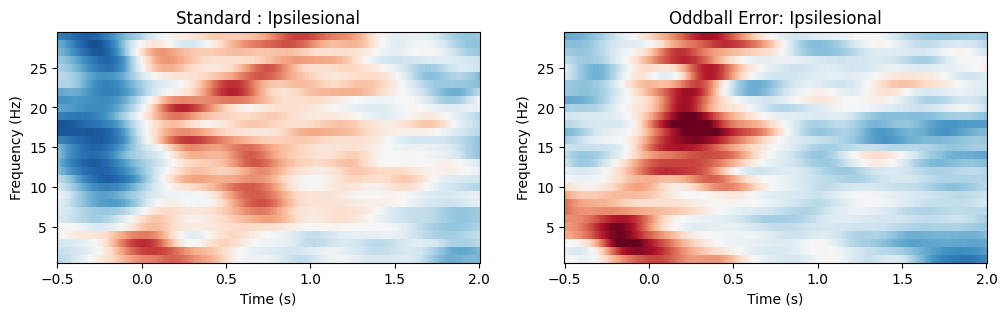

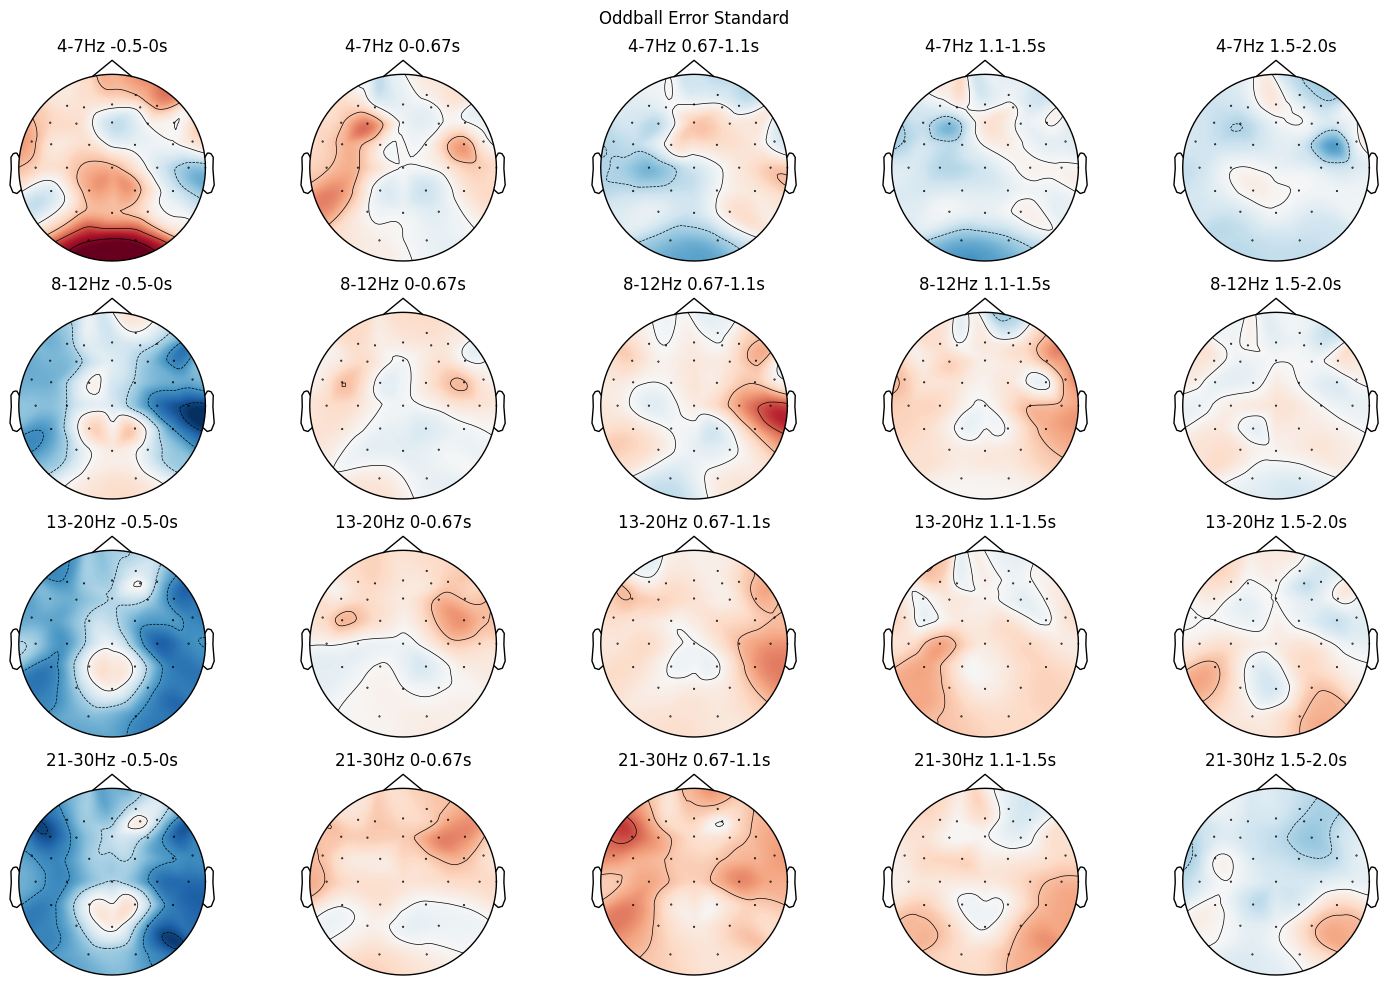

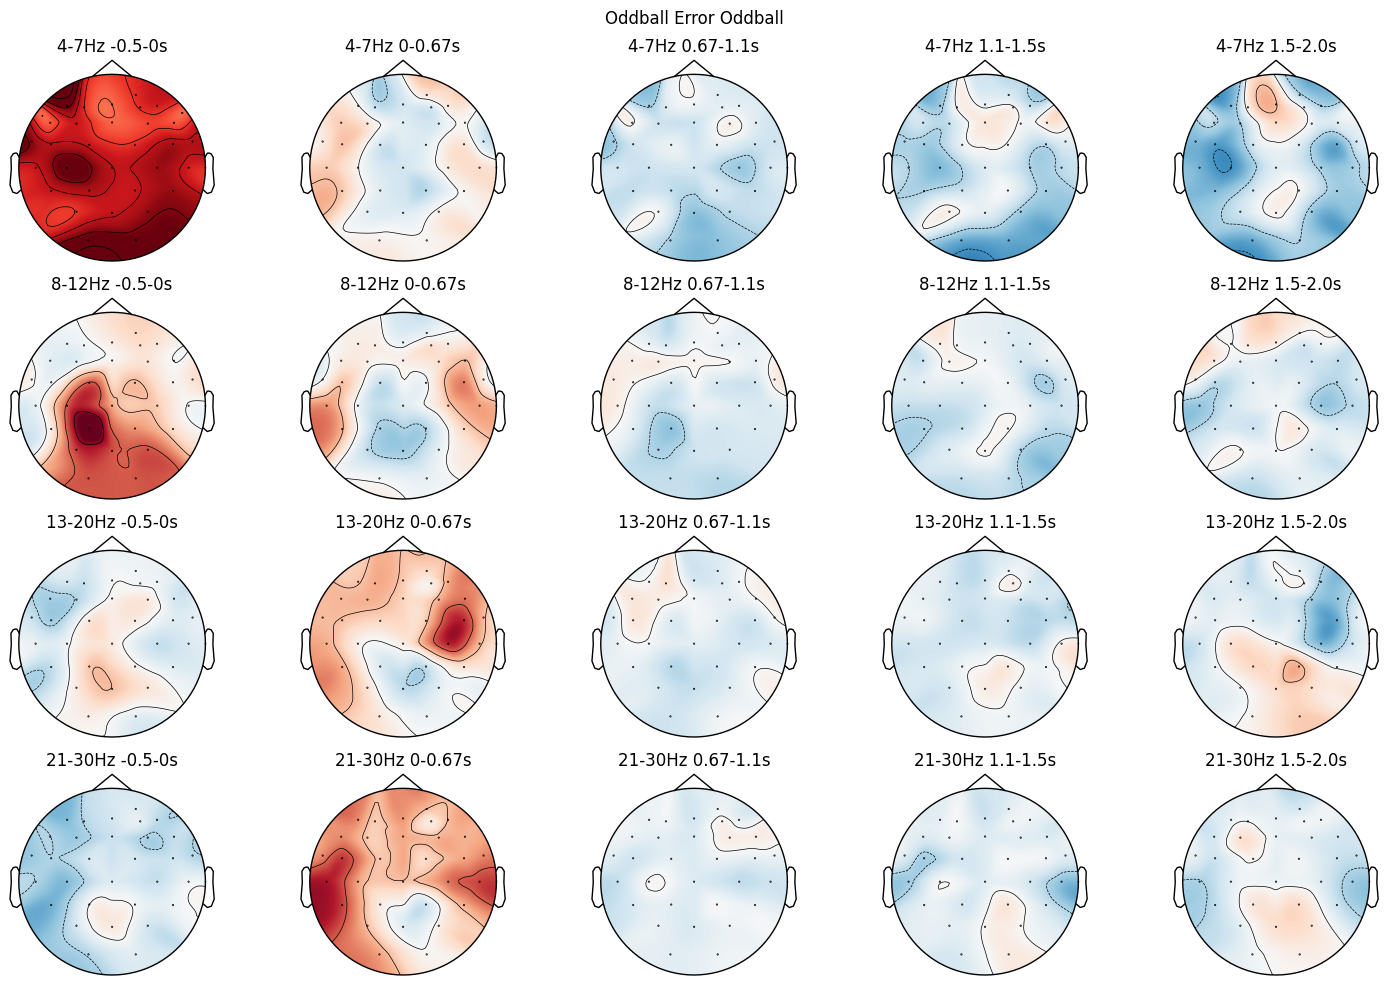

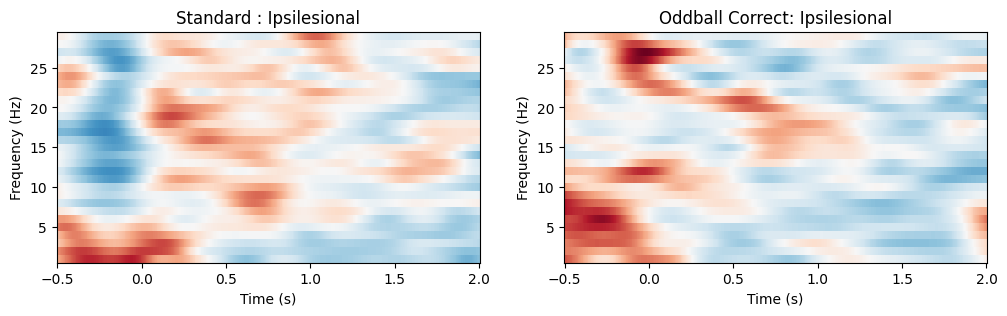

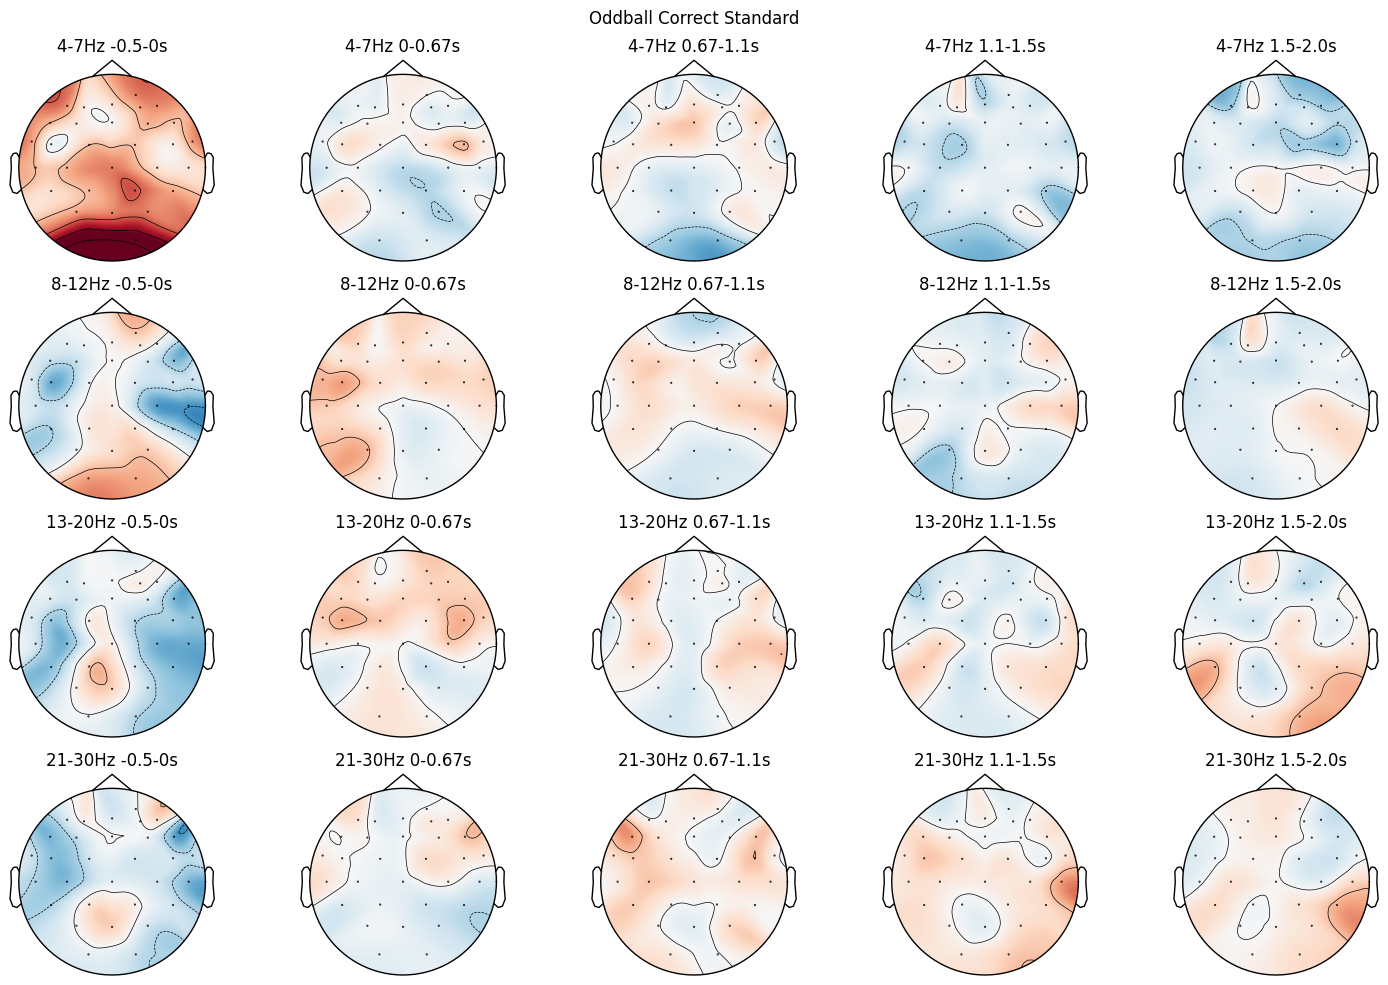

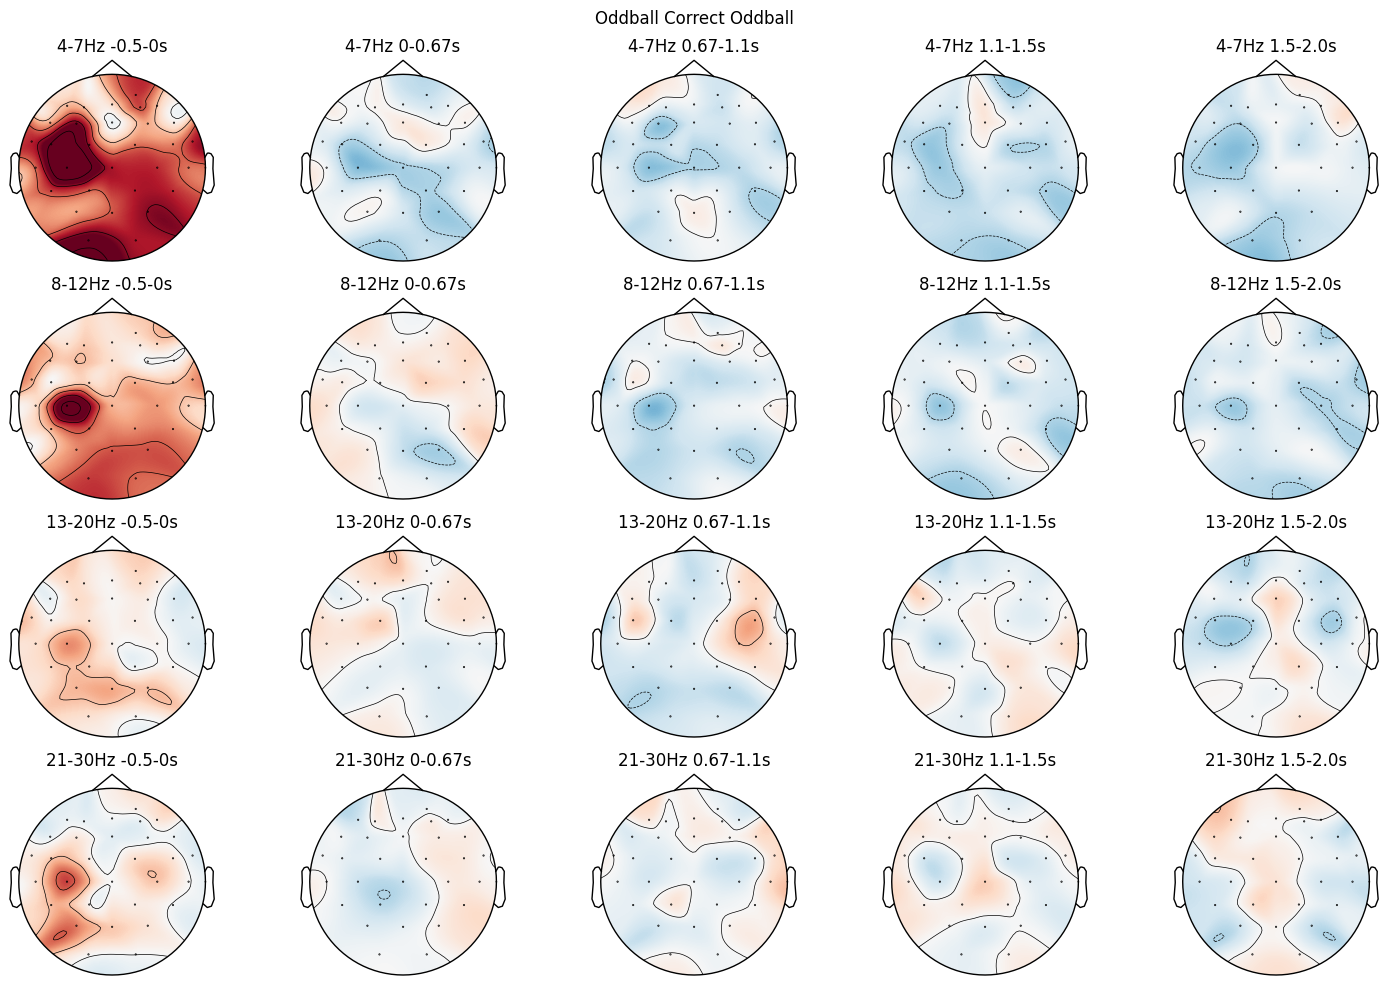

In [6]:
resp = {'007':0,'008':1,'011':2,'013':3}
non_resp = {'008':1,'011':2,'013':3,'014':4,'015':5}
event_id = dict( Standard=1,Oddball=101)
ch_picks = ['FP2', 'AF8',  'AF4', 'AFz', 'AF3', 'AF7', 'F8', 'F4', 'Fz', 'F3', 'F7', 'FT10', 'FC6', 'FC2', 'FC1', 'FC5', 'FT9',
            'T8', 'C4', 'Cz', 'C3', 'T7', 'CP6', 'CP2', 'CP1', 'CP5', 'P4', 'Pz', 'P3', 'O2', 'O1']

task_res = ['Oddball Error', 'Oddball Correct']
tfr_typ_data_E = []
tfr_typ_data_NE = []
tfr_odd_data_E = []
tfr_odd_data_NE = []

for ires, res in enumerate(task_res):
    if res == 'Oddball Error':
        resp_idx = list(resp.values())
        
        tfr_typ_avg = []
        tfr_odd_avg = []
        for i in resp_idx:
            tfr_typ_data_E.append(tfrs_all[i][0].copy().pick(ch_picks).get_data())
            tfr_avg = tfrs_all[i][0].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_typ_avg = mne.time_frequency.AverageTFR(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
            tfr_typ_avg.append(tfrs_typ_avg)
            
            tfr_odd_data_E.append(tfrs_all[i][2].copy().pick(ch_picks).get_data())
            odd_avg = tfrs_all[i][2].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_odd_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
            tfr_odd_avg.append(tfrs_odd_avg)

    else:
        resp_idx = list(non_resp.values())
        tfr_typ_avg = []
        tfr_odd_avg = []
        for i in resp_idx:
            tfr_typ_data_NE.append(tfrs_all[i][1].copy().pick(ch_picks).get_data())
            tfr_avg = tfrs_all[i][1].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_typ_avg = mne.time_frequency.AverageTFR(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
            tfr_typ_avg.append(tfrs_typ_avg)
            
            tfr_odd_data_NE.append(tfrs_all[i][3].copy().pick(ch_picks).get_data())
            odd_avg = tfrs_all[i][3].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_odd_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
            tfr_odd_avg.append(tfrs_odd_avg)    


    if baseline_avg ==True:
        vmin, vmax = -0.5, 0.5  # set min and max ERDS values in plot
    else:
        vmin, vmax = -10, 10  # set min and max ERDS values in plot
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    
    tfr_typ_avg_resp = tfr_typ_avg[0]
    for i in range(1, len(tfr_typ_avg)):
        print(i)
        tfr_typ_avg_resp += tfr_typ_avg[i]
    tfr_typ_avg_resp = tfr_typ_avg_resp/(i+1)
        
    tfr_odd_avg_resp = tfr_odd_avg[0]
    for i in range(1, len(tfr_odd_avg)):
        tfr_odd_avg_resp += tfr_odd_avg[i]
    tfr_odd_avg_resp = tfr_odd_avg_resp/(i+1)
    
    tfr_diff_avg_resp=tfr_odd_avg_resp-tfr_typ_avg_resp

    
# Channel to plot from average
    ch_plot = 'CP2'
    ch_plot_name = ch_plot
    fig, axes = plt.subplots(1,2, figsize = (12,3))

    avg = True
    region = 'ipsi'
    
    if avg==True:
        if region == 'FC':
            ch_picks_ipsi =['FC2','FC1','Cz','Fz']
            ch_plot_name = 'Fronto-Central'
        elif region == 'CP':
            ch_picks_ipsi =['CP2','CP1','Cz','Pz']
            ch_plot_name = 'Centro-Parietal'
        elif region == 'ipsi':
            ch_picks_ipsi =['FC6','C4','FC2']
            ch_plot_name = 'Ipsilesional'
            
        tfr_typ_avg_resp1 = tfr_typ_avg_resp.copy().pick(ch_picks_ipsi).get_data().mean(axis=0)
        tfr_typ_avg_resp1 = tfr_typ_avg_resp1.reshape(1,tfr_typ_avg_resp1.shape[0],tfr_typ_avg_resp1.shape[1])
        tfr_typ_avg_resp1 = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_typ_avg_resp1, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
        
        tfr_odd_avg_resp1 = tfr_odd_avg_resp.copy().pick(ch_picks_ipsi).get_data().mean(axis=0)
        tfr_odd_avg_resp1 = tfr_odd_avg_resp1.reshape(1,tfr_odd_avg_resp1.shape[0],tfr_odd_avg_resp1.shape[1])
        tfr_odd_avg_resp1 = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_odd_avg_resp1, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)


        tfr_typ_avg_resp1.plot(
                            ch_picks[0],
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[0],
                            mask_style="mask",
                            show=False,
                        )
        tfr_odd_avg_resp1.plot(
                            ch_picks[0],
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[1],
                            mask_style="mask",
                            show=False                )

        tfr_diff_avg_resp1=tfr_odd_avg_resp1-tfr_typ_avg_resp1


        axes[0].set_title(f'Standard : {ch_plot_name}')
        axes[1].set_title(f'{res}: {ch_plot_name}')

    
    else:


        tfr_typ_avg_resp.plot(
                            ch_plot,
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[0],
                            mask_style="mask",
                            show=False,
                        )
        
        tfr_odd_avg_resp.plot(
                            ch_plot,
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[1],
                            mask_style="mask",
                            show=False                )

    
        axes[0].set_title(f'Standard : {ch_plot_name}')
        axes[1].set_title(f'{res}: {ch_plot_name}')
    
    
    fmins = [4,8,13,21]
    fmaxs = [7,12,20,30]
        
    f_max_time_avg = round((sum(f_max_time)/len(f_max_time)),2)
    tmins = [-0.5, 0, f_max_time_avg , 1.1, 1.5]
    tmaxs = [0, f_max_time_avg, 1.1, 1.5, 2.0]
    fig1, axes1_row = plt.subplots(len(fmins),len(tmins),figsize=(15,10))
    fig2, axes2_row = plt.subplots(len(fmins),len(tmins),figsize=(15,10))
    
    for axes1, fmin,fmax in zip(axes1_row, fmins,fmaxs):
        for tmin,tmax,ax1 in zip(tmins,tmaxs,axes1):
            tfr_typ_avg_resp.plot_topomap(tmin=tmin, tmax=tmax,fmin=fmin, fmax=fmax,axes=ax1,show=False,vlim=(vmin,vmax),colorbar=False)
            ax1.set_title(f'{fmin}-{fmax}Hz {tmin}-{tmax}s')
    fig1.suptitle(f'{res} Standard')
    fig1.tight_layout()
    for axes2, fmin,fmax in zip(axes2_row, fmins,fmaxs):
        for tmin,tmax,ax2 in zip(tmins,tmaxs,axes2):
            tfr_odd_avg_resp.plot_topomap(tmin=tmin, tmax=tmax,fmin=fmin, fmax=fmax,axes=ax2,show=False,vlim=(vmin,vmax),colorbar=False)
            ax2.set_title(f'{fmin}-{fmax}Hz {tmin}-{tmax}s')
    fig2.suptitle(f'{res} Oddball')
    fig2.tight_layout()




Statistical Test

In [7]:
import scipy
chn = [  'AF4', 'AFz', 'AF3', 'F4', 'Fz', 'F3', 'FC6', 'FC2', 'FC1', 'FC5', 
            'C4', 'Cz', 'C3', 'CP6', 'CP2', 'CP1', 'CP5', 'P4', 'Pz', 'P3', 'O2', 'O1']

X1 = np.concatenate((tfr_odd_data_E[0], tfr_odd_data_E[1], tfr_odd_data_E[2], tfr_odd_data_E[3]), axis=0)
X2 = np.concatenate((tfr_odd_data_NE[0], tfr_odd_data_NE[1], tfr_odd_data_NE[2], tfr_odd_data_NE[3]), axis=0)
this_tfr1 = mne.time_frequency.AverageTFR(tfrs_all[1][0].copy().pick(ch_picks).info, X1, tfrs_all[1][0].times, tfrs_all[1][0].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
this_tfr2 = mne.time_frequency.AverageTFR(tfrs_all[0][0].copy().pick(ch_picks).info, X2, tfrs_all[0][0].times, tfrs_all[0][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)

X1 = this_tfr1.pick(chn).crop(crop_min,crop_max).get_data()
X2 = this_tfr2.pick(chn).crop(crop_min,crop_max).get_data()
this_tfr1 = this_tfr1.pick(chn).crop(crop_min,crop_max)
freqs = this_tfr1.freqs
X=[X1,X2]
X = [np.transpose(x, (0, 2, 3, 1)) for x in X]

# our data at each observation is of shape frequencies × times × channels
adjacency, ch_names = find_ch_adjacency(this_tfr1.info, ch_type="eeg")

tfr_adjacency = combine_adjacency(len(freqs), len(this_tfr1.times), adjacency)
# This time we don't calculate a threshold based on the F distribution.
# We might as well select an arbitrary threshold for cluster forming
alpha_cluster_forming = 0.001

tfr_threshold = 3.0
n_conditions = len(event_id)
n_observations = len(X[0])
dfn = n_conditions - 1
dfd = n_observations - n_conditions

# Note: we calculate 1 - alpha_cluster_forming to get the critical value
# on the right tail
tfr_threshold = scipy.stats.f.ppf(1 - alpha_cluster_forming, dfn=dfn, dfd=dfd)
# run cluster based permutation analysis
tfr_threshold

/tmp/ipykernel_185008/1155775354.py:7: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  this_tfr1 = mne.time_frequency.AverageTFR(tfrs_all[1][0].copy().pick(ch_picks).info, X1, tfrs_all[1][0].times, tfrs_all[1][0].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
/tmp/ipykernel_185008/1155775354.py:8: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  this_tfr2 = mne.time_frequency.AverageTFR(tfrs_all[0][0].copy().pick(ch_picks).info, X2, tfrs_all[0][0].times, tfrs_all[0][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 22


11.206770393263392

In [8]:
cluster_stats = spatio_temporal_cluster_test(
    X,
    n_permutations=500,
    threshold=tfr_threshold,
    tail=0,
    n_jobs=100,
    buffer_size=None,
    adjacency=tfr_adjacency,
)

stat_fun(H1): min=5.216689036416475e-11 max=26.944575827148807
Running initial clustering …
Found 24 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

/home/malann/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


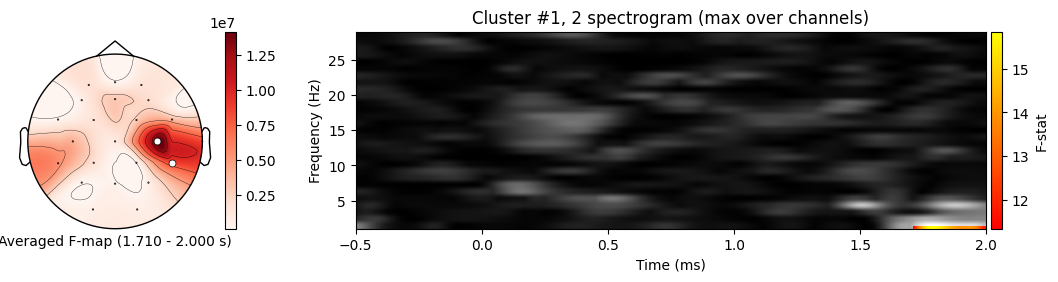

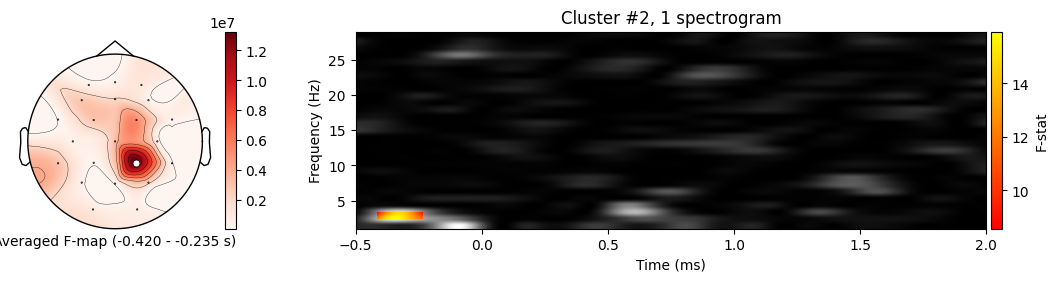

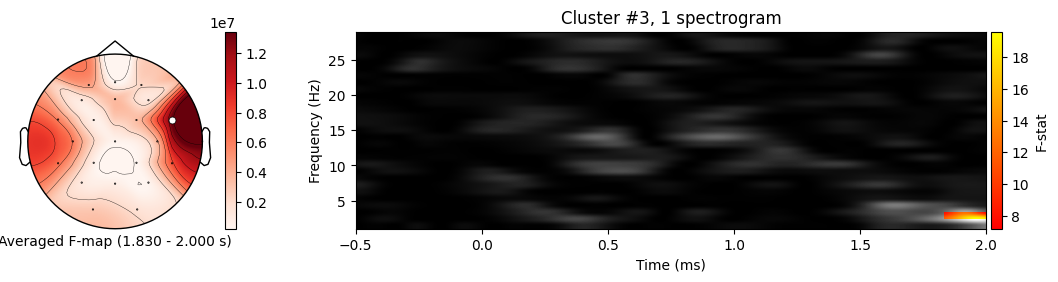

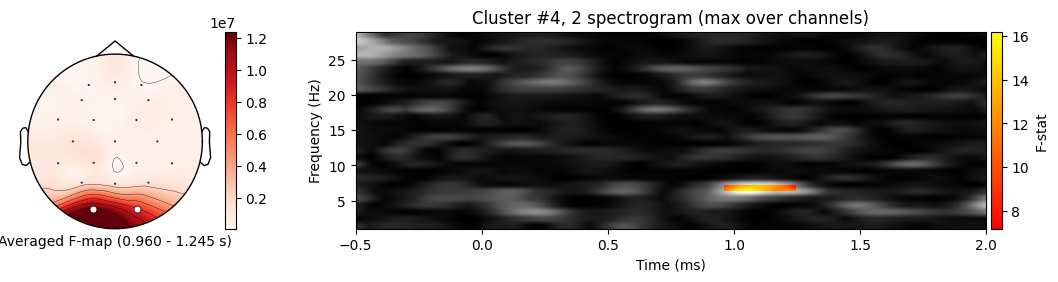

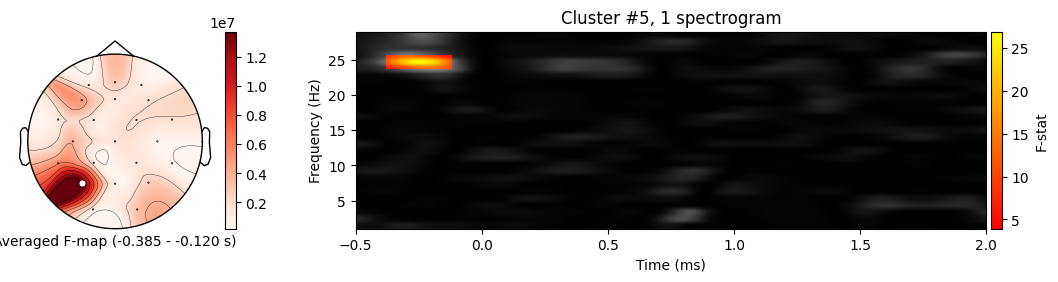

In [9]:
p_accept=0.3
F_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    freq_inds, time_inds, space_inds = clusters[clu_idx]
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)
    freq_inds = np.unique(freq_inds)

    # get topography for F stat
    f_map = F_obs[freq_inds].mean(axis=0)
    f_map = f_map[time_inds].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = this_tfr1.times[time_inds]

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3), layout="constrained")

    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], this_tfr1.info, tmin=0)
    f_evoked.plot_topomap(
        times=0,
        mask=mask,
        axes=ax_topo,
        cmap="Reds",
        vlim=(np.min, np.max),
        show=False,
        colorbar=False,
        mask_params=dict(markersize=10),
    )
    image = ax_topo.images[0]

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        "Averaged F-map ({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
    )

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title("")

    # add new axis for spectrogram
    ax_spec = divider.append_axes("right", size="300%", pad=1.2)
    title = f"Cluster #{i_clu + 1}, {len(ch_inds)} spectrogram"
    if len(ch_inds) > 1:
        title += " (max over channels)"
    F_obs_plot = F_obs[..., ch_inds].max(axis=-1)
    F_obs_plot_sig = np.zeros(F_obs_plot.shape) * np.nan
    F_obs_plot_sig[tuple(np.meshgrid(freq_inds, time_inds))] = F_obs_plot[
        tuple(np.meshgrid(freq_inds, time_inds))
    ]

    for f_image, cmap in zip([F_obs_plot, F_obs_plot_sig], ["gray", "autumn"]):
        c = ax_spec.imshow(
            f_image,
            cmap=cmap,
            aspect="auto",
            origin="lower",
            extent=[this_tfr1.times[0], this_tfr1.times[-1], freqs[0], freqs[-1]],
        )
    ax_spec.set_xlabel("Time (ms)")
    ax_spec.set_ylabel("Frequency (Hz)")
    ax_spec.set_title(title)

    # add another colorbar
    ax_colorbar2 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(c, cax=ax_colorbar2)
    ax_colorbar2.set_ylabel("F-stat")

    # clean up viz
plt.show()

# Plot DBS ERDS 

In [8]:
dbs_chs = {'015':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'014':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'013':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'011':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'008':'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)',
'007':'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)'
}

In [36]:
dbs_chs = {'015':'DBS6-7',
'014':'DBS3-4',
'013':'DBS7-8',
'011':'DBS1-2',
'008':'DBS3-6',
'007':'DBS3-6'
}

C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:23: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][0].copy().pick(dbs_chs['015']).info, tfr_dbs_avg, tfrs_dbs_all[i][0].times, tfrs_dbs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:31: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][2].copy().pick(dbs_chs['015']).info, odd_dbs_avg, tfrs_dbs_all[i][2].times, tfrs_dbs_all[i][2].freqs,comment=aff_cond_plot[2],events

1
2
3
No baseline correction applied
No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:71: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_dbs_typ_avg_resp.plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:79: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_dbs_odd_avg_resp.plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:88: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_dbs_diff_avg_resp.plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:41: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][1].copy().pick(dbs_chs['015']).info, tfr_dbs_avg, tfrs_dbs_all[i][1].times, tfrs_dbs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
C:\Users\malan

1
2
3
4
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:41: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][1].copy().pick(dbs_chs['015']).info, tfr_dbs_avg, tfrs_dbs_all[i][1].times, tfrs_dbs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:48: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][3].copy().pick(dbs_chs['015']).info, odd_dbs_avg, tfrs_dbs_all[i][3].times, tfrs_dbs_all[i][3].freqs,comment=aff_cond_plot[3],events

No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:71: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_dbs_typ_avg_resp.plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:79: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_dbs_odd_avg_resp.plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1780280\615930318.py:88: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_dbs_diff_avg_resp.plot(


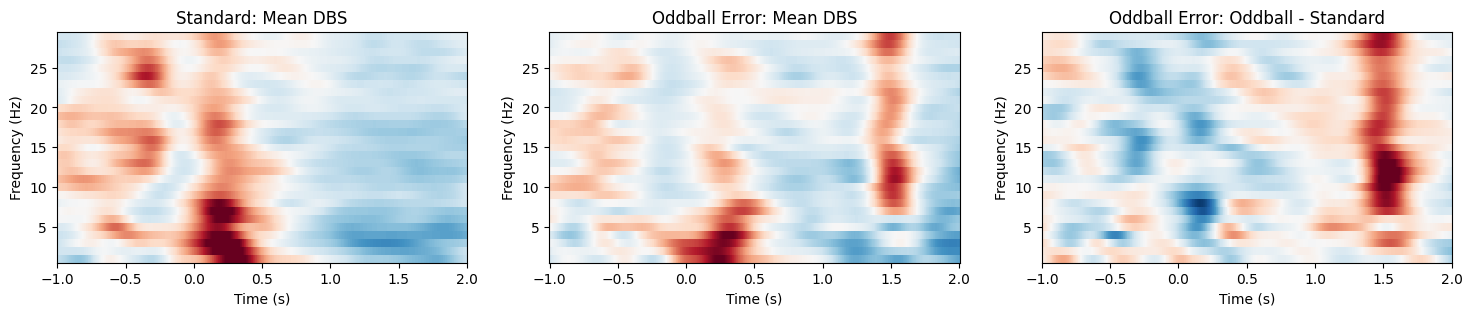

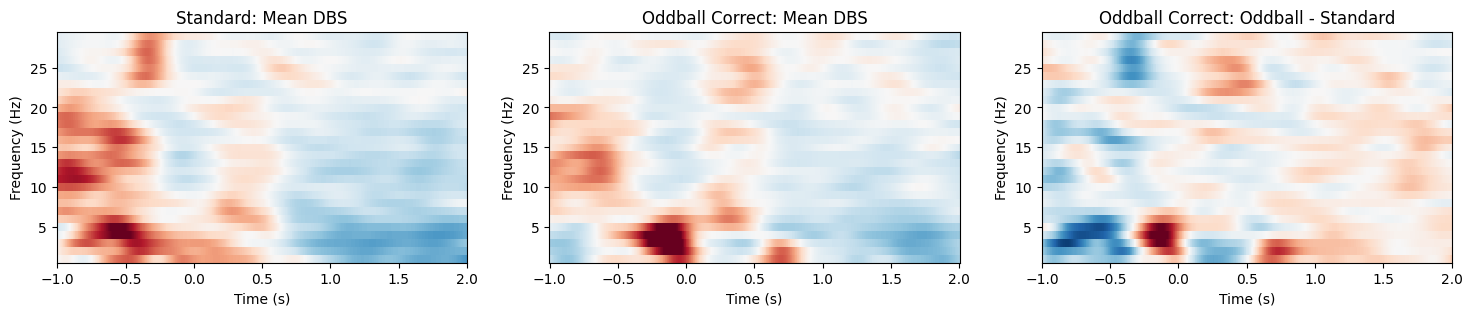

In [12]:
resp = {'007':0,'008':1,'011':2,'013':3}
non_resp = {'008':1,'011':2,'013':3,'014':4,'015':5}

task_res = ['Oddball Error', 'Oddball Correct'] 
tfr_dbs_typ_data_E = []
tfr_dbs_typ_data_NE = []
tfr_dbs_odd_data_E = []
tfr_dbs_odd_data_NE = []

for ires, res in enumerate(task_res):
    if res == 'Oddball Error':
        resp_idx = list(resp.values())
    else:
        resp_idx = list(non_resp.values())
        
    tfr_dbs_typ_avg = []
    tfr_dbs_odd_avg = []
  
    for i_idx, i in enumerate(resp_idx):

        if res == 'Oddball Error':
            ch_picks = tfrs_dbs_all[i][0].copy().pick(dbs_chs[list(resp.keys())[i_idx]]).ch_names
            
            tfr_dbs_typ_data_E.append(tfrs_dbs_all[i][0].copy().pick(ch_picks).get_data())
    
            tfr_dbs_avg1 = tfrs_dbs_all[i][0].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #tfr_dbs_avg1 = (tfr_dbs_avg1-tfr_dbs_avg1.min())/(tfr_dbs_avg1.max()-tfr_dbs_avg1.min()) 
            tfr_dbs_avg = tfr_dbs_avg1.reshape(1,tfr_dbs_avg1.shape[0],tfr_dbs_avg1.shape[1])
    
            tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][0].copy().pick(dbs_chs['015']).info, tfr_dbs_avg, tfrs_dbs_all[i][0].times, tfrs_dbs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
            tfr_dbs_typ_avg.append(tfrs_dbs_typ_avg)

            
            tfr_dbs_odd_data_E.append(tfrs_dbs_all[i][2].copy().pick(ch_picks).get_data())

            odd_dbs_avg1 = tfrs_dbs_all[i][2].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #odd_dbs_avg1 = (odd_dbs_avg1-odd_dbs_avg1.min())/(odd_dbs_avg1.max()-odd_dbs_avg1.min()) 
            odd_dbs_avg = odd_dbs_avg1.reshape(1,odd_dbs_avg1.shape[0],odd_dbs_avg1.shape[1])
    
            
            tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][2].copy().pick(dbs_chs['015']).info, odd_dbs_avg, tfrs_dbs_all[i][2].times, tfrs_dbs_all[i][2].freqs,comment=aff_cond_plot[2],events=epochs.events,event_id=event_id)
            tfr_dbs_odd_avg.append(tfrs_dbs_odd_avg)
       
        else:
            ch_picks = tfrs_dbs_all[i][1].copy().pick(dbs_chs[list(non_resp.keys())[i_idx]]).ch_names
            
            tfr_dbs_typ_data_NE.append(tfrs_dbs_all[i][1].copy().pick(ch_picks).get_data())

            tfr_dbs_avg1 = tfrs_dbs_all[i][1].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #tfr_dbs_avg1 = (tfr_dbs_avg1-tfr_dbs_avg1.min())/(tfr_dbs_avg1.max()-tfr_dbs_avg1.min()) 
            tfr_dbs_avg = tfr_dbs_avg1.reshape(1,tfr_dbs_avg1.shape[0],tfr_dbs_avg1.shape[1])
    
            tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][1].copy().pick(dbs_chs['015']).info, tfr_dbs_avg, tfrs_dbs_all[i][1].times, tfrs_dbs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
            tfr_dbs_typ_avg.append(tfrs_dbs_typ_avg)

            tfr_dbs_odd_data_NE.append(tfrs_dbs_all[i][3].copy().pick(ch_picks).get_data())

            odd_dbs_avg1 = tfrs_dbs_all[i][3].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #odd_dbs_avg1 = (odd_dbs_avg1-odd_dbs_avg1.min())/(odd_dbs_avg1.max()-odd_dbs_avg1.min()) 
            odd_dbs_avg = odd_dbs_avg1.reshape(1,odd_dbs_avg1.shape[0],odd_dbs_avg1.shape[1])
    
            tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][3].copy().pick(dbs_chs['015']).info, odd_dbs_avg, tfrs_dbs_all[i][3].times, tfrs_dbs_all[i][3].freqs,comment=aff_cond_plot[3],events=epochs.events,event_id=event_id)
            tfr_dbs_odd_avg.append(tfrs_dbs_odd_avg)
   
    vmin, vmax = -1, 1  # set min and max ERDS values in plot
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    
    tfr_dbs_typ_avg_resp = tfr_dbs_typ_avg[0]
    for i in range(1, len(tfr_dbs_typ_avg)):
        print(i)
        tfr_dbs_typ_avg_resp += tfr_dbs_typ_avg[i]
    tfr_dbs_typ_avg_resp = tfr_dbs_typ_avg_resp/(i+1)
    
    
    tfr_dbs_odd_avg_resp = tfr_dbs_odd_avg[0]
    for i in range(1, len(tfr_dbs_odd_avg)):
        tfr_dbs_odd_avg_resp += tfr_dbs_odd_avg[i]
    tfr_dbs_odd_avg_resp = tfr_dbs_odd_avg_resp/(i+1)
       
    fig, axes = plt.subplots(1,3, figsize = (18,3))
    tfr_dbs_typ_avg_resp.plot(
                        dbs_chs['015'],
                        colorbar=False,
                        cnorm=cnorm,
                        axes = axes[0],
                        mask_style="mask",
                        show=False
                    )
    tfr_dbs_odd_avg_resp.plot(
                        dbs_chs['015'],
                        colorbar=False,
                        cnorm=cnorm,
                        axes = axes[1],
                        mask_style="mask",
                        show=False          )
    
    tfr_dbs_diff_avg_resp=tfr_dbs_odd_avg_resp-tfr_dbs_typ_avg_resp
    tfr_dbs_diff_avg_resp.plot(
                        dbs_chs['015'],
                        colorbar=False,
                        cnorm=cnorm,
                        axes = axes[2],
                        mask_style="mask",
                        show=False,
                    )
    axes[0].set_title(f'Standard: Mean DBS')
    axes[1].set_title(f'{res}: Mean DBS')
    axes[2].set_title(f'{res}: Oddball - Standard')

In [ ]:
import scipy

X1 = np.concatenate((tfr_dbs_odd_data_E[0], tfr_dbs_odd_data_E[1], tfr_dbs_odd_data_E[2], tfr_dbs_odd_data_E[3]), axis=0)
X2 = np.concatenate((tfr_dbs_typ_data_E[0], tfr_dbs_typ_data_E[1], tfr_dbs_typ_data_E[2], tfr_dbs_typ_data_E[3]), axis=0)

X1 = tfr_dbs_odd_data_E[2]
X2 = tfr_dbs_typ_data_E[2]


this_tfr1 = mne.time_frequency.EpochsTFR(tfrs_dbs_all[1][0].copy().pick([dbs_chs['007']]).info, X1, tfrs_dbs_all[1][0].times, tfrs_dbs_all[1][0].freqs,comment=aff_cond_plot[1],events=tfrs_dbs_all[1][0].events,event_id=event_id)
this_tfr2 = mne.time_frequency.EpochsTFR(tfrs_dbs_all[0][0].copy().pick([dbs_chs['007']]).info, X2, tfrs_dbs_all[0][0].times, tfrs_dbs_all[0][0].freqs,comment=aff_cond_plot[0],events=tfrs_dbs_all[0][0].events,event_id=event_id)

X1 = this_tfr1.crop(crop_min,crop_max).get_data()
X2 = this_tfr2.crop(crop_min,crop_max).get_data()

freqs = this_tfr1.freqs
epochs_power_1 = this_tfr1.data[:, 0, :, :]  # only 1 channel as 3D matrix
epochs_power_2 = this_tfr2.data[:, 0, :, :]  # only 1 channel as 3D matrix

In [ ]:
alpha_cluster_forming = 0.001

n_conditions = len(event_id)
n_observations = len(X[0])
dfn = n_conditions - 1
dfd = n_observations - n_conditions
tfr_threshold = scipy.stats.f.ppf(1 - alpha_cluster_forming, dfn=dfn, dfd=dfd)


F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    [epochs_power_1, epochs_power_2],
    out_type="mask",
    n_permutations=500,
    threshold=tfr_threshold,
    tail=0,
    seed=np.random.default_rng(seed=8675309),
)

In [ ]:
p_accept=0.5

times = 1e3 * this_tfr1.times  # change unit to ms

fig, (ax, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 9), layout="constrained")

# Compute the difference in evoked to determine which was greater since
# we used a 1-way ANOVA which tested for a difference in population means
evoked_power_1 = epochs_power_1.mean(axis=0)
evoked_power_2 = epochs_power_2.mean(axis=0)
evoked_power_contrast = evoked_power_1 - evoked_power_2
signs = np.sign(evoked_power_contrast)

# Create new stats image with only significant clusters
F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= p_accept:
        F_obs_plot[c] = F_obs[c] * signs[c]

ax.imshow(
    F_obs,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="gray",
)
max_F = np.nanmax(abs(F_obs_plot))
ax.imshow(
    F_obs_plot,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    vmin=-max_F,
    vmax=max_F,
)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"Induced power : Mean DBS channel)")

this_tfr1.average().plot(     dbs_chs['007'],
                    colorbar=False,
                         axes=ax2,
                    cnorm=cnorm     ,show=False       )
this_tfr2.average().plot(     dbs_chs['007'],
                    colorbar=False,
                         axes=ax3,
                    cnorm=cnorm,show=False     )
fig.show()